In [31]:
# import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from config import client, client_secret

In [5]:
# define path to csv file
file_path = 'data/income-inequality-.csv'

# read csv intp pandas df
df = pd.read_csv(file_path)
df.head()

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_name,county_fips,...,Gini_index,LL_95CI,UL_95CI,se,rse,CA_decile,CA_RR,Median_HH_income,Median_HH_decile,version
0,556,Income inequality: Gini coefficient describing...,2005-2007,9,Total,CA,6,California,NaN,NaN,...,0.468,0.465617,0.470383,0.001216,0.259787,NaN,NaN,NaN,NaN,03/26/2014 12:00:00 AM
1,556,Income inequality: Gini coefficient describing...,2006-2010,9,Total,CA,6,California,NaN,NaN,...,0.469,0.467809,0.470191,0.000608,0.129617,NaN,NaN,NaN,NaN,03/26/2014 12:00:00 AM
2,556,Income inequality: Gini coefficient describing...,2008-2010,9,Total,CA,6,California,NaN,NaN,...,0.471,0.468617,0.473383,0.001216,0.258133,NaN,NaN,NaN,NaN,03/26/2014 12:00:00 AM
3,556,Income inequality: Gini coefficient describing...,2005-2007,9,Total,CO,6001,Alameda,Alameda,6001.0,...,0.455,0.449043,0.460957,0.003040,0.668025,NaN,0.972222,66430.0,3.0,03/26/2014 12:00:00 AM
4,556,Income inequality: Gini coefficient describing...,2005-2007,9,Total,CO,6003,Alpine,Alpine,6003.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03/26/2014 12:00:00 AM


In [6]:
df.describe()

,ind_id,race_eth_code,geotypevalue,county_fips,region_code,Number_Households,Gini_index,LL_95CI,UL_95CI,se,rse,CA_decile,CA_RR,Median_HH_income,Median_HH_decile
count,4788.0,4788.0,4788.000000,4743.000000,4785.000000,4.788000e+03,2345.000000,2345.000000,2345.000000,2345.000000,2345.000000,2140.000000,2342.000000,1967.000000,1967.000000
mean,556.0,9.0,40680.393484,6057.977862,7.930408,3.108647e+04,0.403342,0.344789,0.462682,0.033734,11.056622,5.498598,0.859480,63383.262328,5.496187
std,0.0,0.0,25836.291577,31.050892,4.564702,3.704397e+05,0.075310,0.101299,0.087781,0.178356,121.118065,2.872464,0.160489,26992.619504,2.864499
min,556.0,9.0,1.000000,6001.000000,1.000000,0.000000e+00,0.004000,0.000000,0.007574,0.000608,0.129617,1.000000,0.008529,13588.000000,1.000000
25%,556.0,9.0,17480.500000,6035.000000,4.000000,2.647500e+02,0.375000,0.314064,0.418596,0.010942,2.643055,3.000000,0.797656,45191.500000,3.000000
50%,556.0,9.0,40382.000000,6059.000000,8.000000,1.253500e+03,0.410000,0.369596,0.452000,0.018845,4.526935,5.000000,0.874066,57240.000000,6.000000
75%,556.0,9.0,60609.500000,6083.000000,12.000000,6.668750e+03,0.443000,0.405851,0.495660,0.039514,10.318185,8.000000,0.944563,75753.000000,8.000000
max,556.0,9.0,87090.000000,6115.000000,14.000000,1.257750e+07,0.775000,0.599851,1.000000,8.544073,5852.104759,10.000000,1.652452,223611.000000,10.000000


In [7]:
# drop rows where gini index or median household income is na
df = df.dropna(subset=['Gini_index', 'Median_HH_income'])
df.describe()

,ind_id,race_eth_code,geotypevalue,county_fips,region_code,Number_Households,Gini_index,LL_95CI,UL_95CI,se,rse,CA_decile,CA_RR,Median_HH_income,Median_HH_decile
count,1967.0,1967.0,1967.000000,1967.000000,1967.000000,1.967000e+03,1967.000000,1967.000000,1967.000000,1967.000000,1967.000000,1807.000000,1967.000000,1967.000000,1967.000000
mean,556.0,9.0,40210.172852,6057.173869,8.791561,3.565121e+04,0.415964,0.372627,0.459301,0.022111,5.429507,5.170448,0.886523,63383.262328,5.496187
std,0.0,0.0,26203.920773,29.458529,4.941290,1.609551e+05,0.051717,0.060967,0.062142,0.017034,4.230913,2.675667,0.110191,26992.619504,2.864499
min,556.0,9.0,135.000000,6001.000000,1.000000,6.700000e+01,0.112000,0.048851,0.175149,0.001216,0.247618,1.000000,0.238806,13588.000000,1.000000
25%,556.0,9.0,15522.000000,6037.000000,4.000000,1.703500e+03,0.386000,0.340117,0.420074,0.010334,2.541930,3.000000,0.823028,45191.500000,3.000000
50%,556.0,9.0,40354.000000,6059.000000,10.000000,8.838000e+03,0.413000,0.377319,0.449319,0.016413,3.993522,5.000000,0.880597,57240.000000,6.000000
75%,556.0,9.0,61068.000000,6079.000000,14.000000,2.311700e+04,0.444000,0.410245,0.487149,0.028571,6.956782,7.000000,0.946638,75753.000000,8.000000
max,556.0,9.0,87090.000000,6115.000000,14.000000,3.241204e+06,0.682000,0.577532,0.935213,0.156231,28.766826,10.000000,1.454158,223611.000000,10.000000


Text(0.5, 1.0, 'Gini_index vs Number of Households')

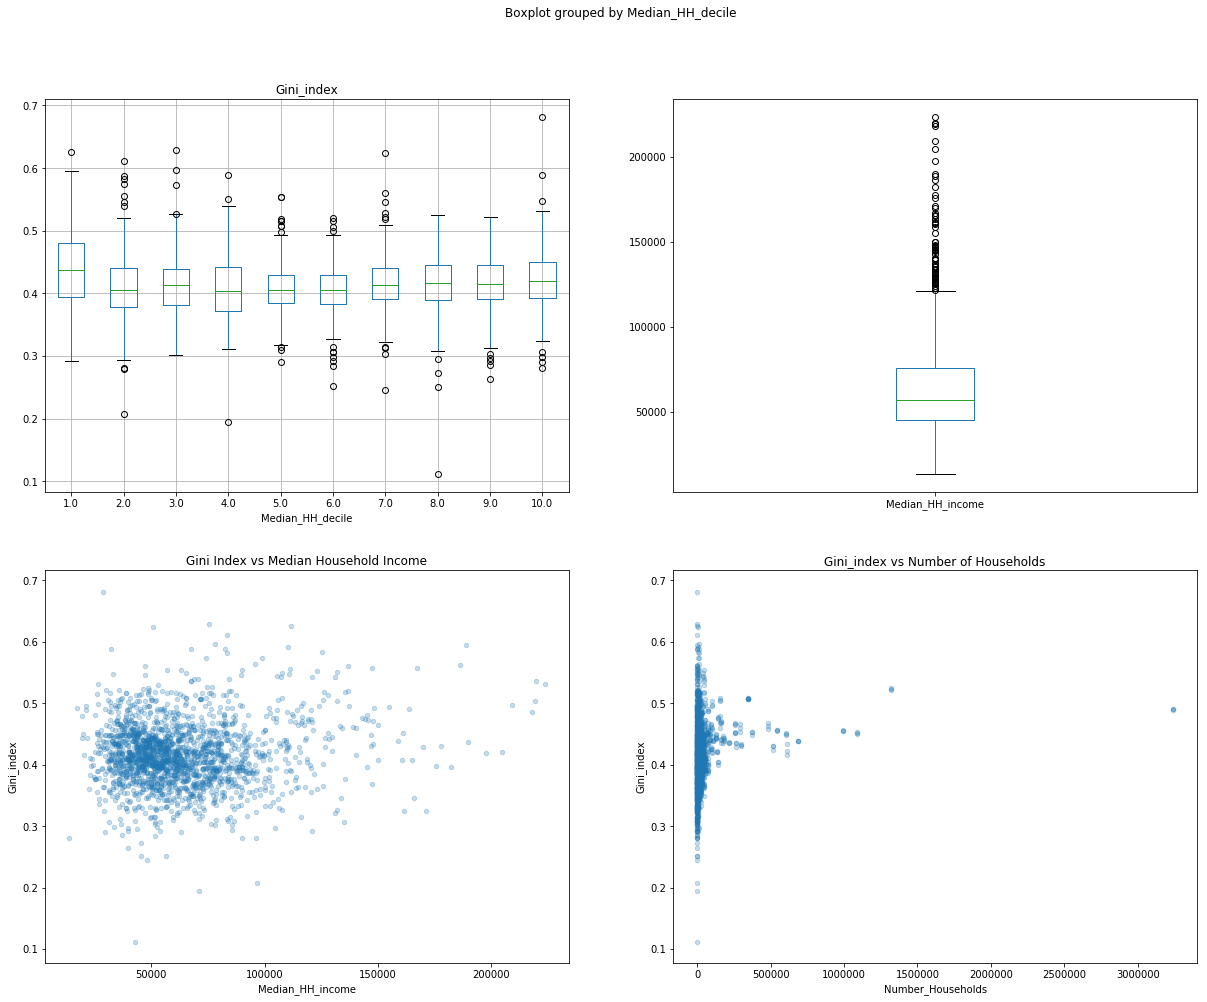

In [48]:
# let's visually explore the data
# create figure and axes objects for the subplots. These are graphed in a 2 x 2 grid
fig = plt.figure(figsize=(20,16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# make the top row box plots for gini and median incomes. This will visualize outliers
df.boxplot(by='Median_HH_decile', column='Gini_index', ax=ax1)
df.plot(kind='box', y='Median_HH_income', ax=ax2)

# Use the bottom row for scatter plots showing relationships between variables
df.plot(kind='scatter', x='Median_HH_income', y='Gini_index', ax=ax3, alpha=0.25)
ax3.set_title('Gini Index vs Median Household Income')

df.plot(kind='scatter', x='Number_Households', y='Gini_index', ax=ax4, alpha=0.25)
ax4.set_title('Gini_index vs Number of Households')

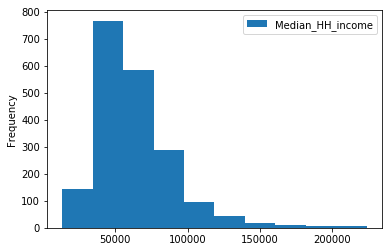

In [17]:
df.plot(kind='hist', y='Median_HH_income', x='reportyear')

In [24]:
# make request to 4square api. Use the county name from the previous df for the locations
# get names of each unique county
counties = df['county_name'].unique()
print(f'There are {len(counties)} unique counties in CA')

There are 58 unique counties in CA


In [133]:
# Define function to build query url
def get_data(county, client=client, client_secret=client_secret, time='any', openNow=0, price='1,2,3,4', v='20191206'):
    """
    Takes the desired parameters, builds the search, and makes an api call to foursquare. Returns a json response.
    
    Currently the valid range of price points are [1,2,3,4], 1 being the least expensive, 4 being the most expensive. 
    For food venues, in the United States, 1 is < $10 an entree, 2 is $10-$20 an entree, 3 is $20-$30 an entree, 4 is > $30 an entree.
    """
    # assemble the parameters into search strings
    base_uri = 'https://api.foursquare.com/v2/venues/explore?'
    near = 'near=' + county + ', CA'
    price = f'price={price}'
    time = f'time={time}'
    openNow = f'openNow={openNow}'
    authentication = f'client_id={client}&client_secret={client_secret}&v={v}'
    
    # join each seach parameter using '&'
    param_str = '&'.join([near, time, openNow, price, authentication])
    search_url = base_uri + param_str
    
    # make the api call
    response = requests.get(search_url)
    return response.json()
    

In [145]:
# Get the following data for each county: venue id, venue name, category name, and price
# price isn't returned in the response, but we can filter for it initially. We'll just need to make 1 request at each price point (1-4)
prices = range(1,5)

# create empty list to hold dictionaries for all venue data
all_venues = []

# loop through all counties
for county in counties:
    print(f'Getting data for {county}...')
    # make an api call for each price point
    for price in prices:
        r = get_data(county, price=price)
        
        # find the number of total results and just move on if it's 0 (don't try to process the data because there isn't any!)
        totalR = r['response']['totalResults']
        if totalR == 0:
            continue

        # locate where the venues data is stored
        venues = r['response']['groups'][0]['items']

        # loop through all the returned venues
        for venue in venues:
            v = venue['venue']

            # initialize empty dictionary to hold data for an individual venue
            venue_dict = {}

            # add data to venue_dict
            venue_dict = {
                'Venue id': v['id'],
                'Venue Name': v['name'],
                'County': county,
                'Price': price
            }

            # get the list of categories. There may be more than 1.
            v_cat = v['categories']    
            # initialize index for number of subcategories
            subcategory = 1

            # Loop through eacch category in the list and extract the category name
            for cat in v_cat:
                # check if the category is the primary key
                if cat['primary']: 
                    venue_dict['Primary category'] = cat['name']
                # otherwise, create a unique column for each non-primary venue category
                else:
                    venue_dict[f'Subcategory {subcategory}'] = cat['name']
                    subcategory += 1

            # append the dictionary to the list for all our venues
            all_venues.append(venue_dict)
            print('Done!')
            
print('All data gathering complete!')

In [146]:
# create a df to see our data for alemeda county
venues_df = pd.DataFrame(all_venues)
venues_df.head()

,County,Price,Primary category,Venue Name,Venue id
0,Alameda,1,Ice Cream Shop,Tucker's Ice Cream,4645bd20f964a5207e461fe3
1,Alameda,1,Burger Joint,In-N-Out Burger,5516cea6498ea63bf9695e68
2,Alameda,1,Brewery,Faction Brewing,50c3b212498ef1fd446e75b2
3,Alameda,1,Café,Julie's Coffee & Tea Shop,4ae61a25f964a520b9a421e3
4,Alameda,1,Pizza Place,The Star,59f68b9286f4cc308a07fe90


In [147]:
venues_df.shape

(2479, 5)

In [148]:
venues_df[venues_df['Price']>1]

,County,Price,Primary category,Venue Name,Venue id
30,Alameda,2,Brewery,Almanac Beer Co. Barrel House & Taproom,5a7283c6e1791027d6d0aae8
31,Alameda,2,Vietnamese Restaurant,Sidestreet Pho,5127d17de4b02a1718eab694
32,Alameda,2,Burmese Restaurant,Burma Superstar,4b3fcf3cf964a52058af25e3
33,Alameda,2,History Museum,"USS Hornet - Sea, Air and Space Museum",4a6cbe2df964a5207dd11fe3
34,Alameda,2,Bakery,Feel Good Bakery,4ad2669df964a52067e120e3
35,Alameda,2,Bar,American Oak,4f178073e4b04c15e631fec6
36,Alameda,2,Tiki Bar,Forbidden Island,45e6b309f964a5204c431fe3
37,Alameda,2,German Restaurant,Speisekammer,463de5c9f964a5203f461fe3
38,Alameda,2,Brewery,Alameda Island Brewing Company,5484ccdf498e236a048e14aa
39,Alameda,2,Sushi Restaurant,Utzutzu,5ad96b9f9be5224883d57fe7


In [149]:
# save venues_df to a csv so we don't have to make the api call every time
venues_df.to_csv('data/venues_data.csv')
print('Dataframe saved to csv!')

Dataframe saved to csv!


In [159]:
# What are the value counts for each county?
venue_counts = venues_df['Primary category'].value_counts()
venue_counts

Coffee Shop                 216
Mexican Restaurant          186
American Restaurant         156
Pizza Place                 138
Sandwich Place              118
Burger Joint                114
Italian Restaurant           80
Café                         79
Brewery                      74
Bakery                       72
Seafood Restaurant           72
Ice Cream Shop               66
Breakfast Spot               63
Fast Food Restaurant         63
Sushi Restaurant             63
Bar                          49
Diner                        46
New American Restaurant      44
Deli / Bodega                39
BBQ Joint                    39
Steakhouse                   37
Restaurant                   36
Chinese Restaurant           34
Wine Bar                     33
Japanese Restaurant          32
Thai Restaurant              28
Winery                       24
Mediterranean Restaurant     23
Dessert Shop                 20
Indian Restaurant            19
                           ... 
Cheese S

In [166]:
# get the frequency of each venue for each county. 
# One hot encode the venue categories
one_hot_venues = pd.get_dummies(venues_df, columns=['Primary category'], prefix='', prefix_sep='')
# gorup by the counties by mean to get the frequency opf each category
freq_df = one_hot_venues.groupby('County').mean()
freq_df

,Price,Afghan Restaurant,American Restaurant,Aquarium,Argentinian Restaurant,Art Museum,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Tiki Bar,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Zoo
County,,,,,,,,,,,,,,,,,,,,,
Alameda,1.524590,0.016393,0.032787,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032787,...,0.016393,0.000000,0.032787,0.000000,0.000000,0.000000,0.000000,0.016393,0.000000,0.000000
Alpine,1.424242,0.000000,0.060606,0.000000,0.000000,0.000000,0.000000,0.060606,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Amador,1.606061,0.000000,0.121212,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.030303,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.000000,0.000000
Butte,1.630769,0.000000,0.015385,0.000000,0.000000,0.000000,0.015385,0.000000,0.000000,0.015385,...,0.000000,0.000000,0.015385,0.000000,0.000000,0.015385,0.000000,0.000000,0.000000,0.000000
Calaveras,1.394737,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.026316,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Colusa,1.333333,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Contra Costa,1.826667,0.000000,0.066667,0.000000,0.000000,0.000000,0.013333,0.026667,0.000000,0.013333,...,0.000000,0.013333,0.026667,0.000000,0.000000,0.013333,0.000000,0.000000,0.000000,0.000000
Del Norte,1.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
El Dorado,1.481481,0.000000,0.074074,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [170]:
# merge the economic and venue data
econ_venue_merged_df = pd.merge(df, freq_df, left_on = 'county_name', right_on='County')
econ_venue_merged_df

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_name,county_fips,...,Tiki Bar,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Zoo
0,556,Income inequality: Gini coefficient describing...,2005-2007,9,Total,CO,6001,Alameda,Alameda,6001.0,...,0.016393,0.0,0.032787,0.0,0.0,0.0,0.0,0.016393,0.0,0.0
1,556,Income inequality: Gini coefficient describing...,2006-2010,9,Total,CO,6001,Alameda,Alameda,6001.0,...,0.016393,0.0,0.032787,0.0,0.0,0.0,0.0,0.016393,0.0,0.0
2,556,Income inequality: Gini coefficient describing...,2008-2010,9,Total,CO,6001,Alameda,Alameda,6001.0,...,0.016393,0.0,0.032787,0.0,0.0,0.0,0.0,0.016393,0.0,0.0
3,556,Income inequality: Gini coefficient describing...,2005-2007,9,Total,PL,562,Alameda city,Alameda,6001.0,...,0.016393,0.0,0.032787,0.0,0.0,0.0,0.0,0.016393,0.0,0.0
4,556,Income inequality: Gini coefficient describing...,2005-2007,9,Total,PL,2980,Ashland CDP,Alameda,6001.0,...,0.016393,0.0,0.032787,0.0,0.0,0.0,0.0,0.016393,0.0,0.0
5,556,Income inequality: Gini coefficient describing...,2005-2007,9,Total,PL,6000,Berkeley city,Alameda,6001.0,...,0.016393,0.0,0.032787,0.0,0.0,0.0,0.0,0.016393,0.0,0.0
6,556,Income inequality: Gini coefficient describing...,2005-2007,9,Total,PL,11964,Castro Valley CDP,Alameda,6001.0,...,0.016393,0.0,0.032787,0.0,0.0,0.0,0.0,0.016393,0.0,0.0
7,556,Income inequality: Gini coefficient describing...,2005-2007,9,Total,PL,20018,Dublin city,Alameda,6001.0,...,0.016393,0.0,0.032787,0.0,0.0,0.0,0.0,0.016393,0.0,0.0
8,556,Income inequality: Gini coefficient describing...,2005-2007,9,Total,PL,26000,Fremont city,Alameda,6001.0,...,0.016393,0.0,0.032787,0.0,0.0,0.0,0.0,0.016393,0.0,0.0
9,556,Income inequality: Gini coefficient describing...,2005-2007,9,Total,PL,33000,Hayward city,Alameda,6001.0,...,0.016393,0.0,0.032787,0.0,0.0,0.0,0.0,0.016393,0.0,0.0


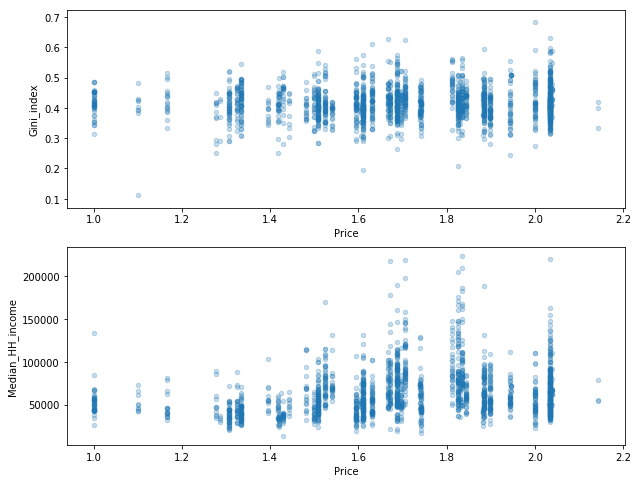

In [180]:
# make visualizations
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
econ_venue_merged_df.plot(kind='scatter', x='Price', y='Gini_index', ax=ax1, alpha=0.25)
ax2 = fig.add_subplot(212)
econ_venue_merged_df.plot(kind='Scatter', x = 'Price', y='Median_HH_income', alpha=0.25, ax=ax2)